In [129]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from scipy import stats
import matplotlib.pyplot as plt

# Load features and labels

In [96]:
feature_path = '../data/03996723-2411-4167-b14b-eb11dfc33124/features.npy'
label_path = '../data/03996723-2411-4167-b14b-eb11dfc33124/labels.npy'
features = np.load(feature_path)
labels = stats.mode(np.load(label_path), axis=1)[0][:, 0]

print('Feature matrix shape:', features.shape)
print('Label matrix shape:', labels.shape)

Feature matrix shape: (128699, 170)
Label matrix shape: (128699,)


In [97]:
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

{0.0: 99967, 1.0: 28732}


# Balance classes and normailze feature matrix

In [98]:
zero_indices = np.where(labels==0)[0]
one_indices = np.where(labels==1)[0]

zero_indices = np.random.choice(zero_indices, size=one_indices.shape[0], replace=False)

indices = np.hstack((zero_indices, one_indices))

np.random.shuffle(indices)

new_labels = labels[indices]
new_features = normalize(features[indices])
print('Feature matrix shape:', new_features.shape)
print('Label matrix shape:', new_labels.shape)

Feature matrix shape: (57464, 170)
Label matrix shape: (57464,)


# Create train set, validation set, and test set

In [120]:
num_classes = 2
split_idx = int(new_features.shape[0] * 0.80)

X_train = new_features[:split_idx]
Y_train = new_labels[:split_idx]

X_test = new_features[split_idx:]
Y_test = new_labels[split_idx:]

Y_train = keras.utils.to_categorical(Y_train, num_classes)
#Y_val = keras.utils.to_categorical(Y_val, num_classes)

print('train data shape:', X_train.shape)
print('train label shape:', Y_train.shape)
#print('val data shape:', X_val.shape)
#print('val label shape:', Y_val.shape)
print('test data shape:', X_test.shape)
print('test label shape:', Y_test.shape)

train data shape: (45971, 170)
train label shape: (45971, 2)
test data shape: (11493, 170)
test label shape: (11493,)


# PCA

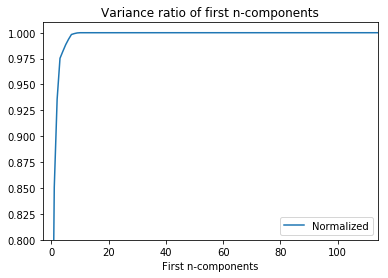

In [121]:


#25% of the data is reserved for testing. This is done for the normalized matrix as well.
#feat_train, feat_test, lbl_train, lbl_test = train_test_split(feat_matrix, lbl_vector, test_size=0.25, random_state=42)
#scale_feat_train, scale_feat_test, scale_lbl_train, scale_lbl_test = train_test_split(scale_feat_matrix, lbl_vector, test_size=0.25, random_state=42)


#PCA is applied to the normalized matrix so it can be compared to the standard matrix in a graph.
pca_norm = PCA(n_components=170, svd_solver='randomized', whiten=True).fit(X_train)
plt.plot(np.cumsum(pca_norm.explained_variance_ratio_), label='Normalized')

#Labeling the graph.
plt.xlabel('First n-components')
plt.title('Variance ratio of first n-components')
plt.axis([-3, 114, .8, 1.01])
# plt.axis([0, 111, 1-1e-13, 1+1e-13])
plt.legend()

In [122]:
#Using the graph as reference, 10 is chosen for n_components.
pca = PCA(n_components=15, svd_solver='randomized', whiten=True).fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

# Create MLP classifier

In [131]:
p = 0.3
model = keras.Sequential()
# Adds a densely-connected layer with 64 units to the model:
model.add(keras.layers.Dense(units=256, 
                             activation='relu', 
                             input_dim=X_train.shape[1]))
model.add(keras.layers.Dense(units=128, 
                             activation='relu', 
                             input_dim=X_train.shape[1]))
# Add another:
model.add(keras.layers.Dropout(p))
model.add(keras.layers.Dense(units=64, activation='relu',
                             kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(keras.layers.Dropout(p))
model.add(keras.layers.Dense(units=64, activation='relu'))

# Add a softmax layer with 10 output units:
model.add(keras.layers.Dense(units=2, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 256)               4096      
_________________________________________________________________
dense_74 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_35 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_36 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_76 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_77 (Dense)             (None, 2)                 130       
Total para

/home/mperf/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


# Train the model

In [132]:
epochs = 100
batch_size = 512
data_path = '.'
data_file = '/DNN_Model-10Second'


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])


checkpointer = keras.callbacks.ModelCheckpoint(filepath=data_path+data_file, 
                                               verbose=1,
                                               monitor='val_acc',
                                               save_best_only=True, 
                                               save_weights_only=False)

callbacks_list = [checkpointer]

H = model.fit(X_train, 
              Y_train, 
              batch_size=batch_size, 
              epochs=epochs, verbose=1, 
              shuffle=True, 
              validation_split=0.2,
              callbacks=callbacks_list)
#validation_data=(X_val, Y_val),

/home/mperf/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


Train on 36776 samples, validate on 9195 samples
Epoch 1/100
36776/36776 [==============================] - 2s 49us/step - loss: 0.6812 - acc: 0.6556 - val_loss: 0.6311 - val_acc: 0.6798

Epoch 00001: val_acc improved from -inf to 0.67983, saving model to ./DNN_Model-10Second
Epoch 2/100
36776/36776 [==============================] - 0s 9us/step - loss: 0.6253 - acc: 0.6860 - val_loss: 0.5958 - val_acc: 0.7108

Epoch 00002: val_acc improved from 0.67983 to 0.71082, saving model to ./DNN_Model-10Second
Epoch 3/100
36776/36776 [==============================] - 0s 9us/step - loss: 0.5944 - acc: 0.6996 - val_loss: 0.5722 - val_acc: 0.7066

Epoch 00003: val_acc did not improve from 0.71082
Epoch 4/100
36776/36776 [==============================] - 0s 9us/step - loss: 0.5751 - acc: 0.7093 - val_loss: 0.5574 - val_acc: 0.7338

Epoch 00004: val_acc improved from 0.71082 to 0.73377, saving model to ./DNN_Model-10Second
Epoch 5/100
36776/36776 [==============================] - 0s 9us/step - lo

36776/36776 [==============================] - 0s 9us/step - loss: 0.4750 - acc: 0.7623 - val_loss: 0.4813 - val_acc: 0.7632

Epoch 00041: val_acc did not improve from 0.76574
Epoch 42/100
36776/36776 [==============================] - 0s 9us/step - loss: 0.4754 - acc: 0.7620 - val_loss: 0.4818 - val_acc: 0.7640

Epoch 00042: val_acc did not improve from 0.76574
Epoch 43/100
36776/36776 [==============================] - 0s 9us/step - loss: 0.4740 - acc: 0.7643 - val_loss: 0.4863 - val_acc: 0.7586

Epoch 00043: val_acc did not improve from 0.76574
Epoch 44/100
36776/36776 [==============================] - 0s 9us/step - loss: 0.4712 - acc: 0.7657 - val_loss: 0.4805 - val_acc: 0.7608

Epoch 00044: val_acc did not improve from 0.76574
Epoch 45/100
36776/36776 [==============================] - 0s 9us/step - loss: 0.4719 - acc: 0.7638 - val_loss: 0.4800 - val_acc: 0.7583

Epoch 00045: val_acc did not improve from 0.76574
Epoch 46/100
36776/36776 [==============================] - 0s 9us/s

36776/36776 [==============================] - 0s 9us/step - loss: 0.4543 - acc: 0.7768 - val_loss: 0.4794 - val_acc: 0.7690

Epoch 00084: val_acc improved from 0.76824 to 0.76900, saving model to ./DNN_Model-10Second
Epoch 85/100
36776/36776 [==============================] - 0s 9us/step - loss: 0.4543 - acc: 0.7747 - val_loss: 0.4859 - val_acc: 0.7672

Epoch 00085: val_acc did not improve from 0.76900
Epoch 86/100
36776/36776 [==============================] - 0s 9us/step - loss: 0.4503 - acc: 0.7756 - val_loss: 0.4809 - val_acc: 0.7701

Epoch 00086: val_acc improved from 0.76900 to 0.77009, saving model to ./DNN_Model-10Second
Epoch 87/100
36776/36776 [==============================] - 0s 9us/step - loss: 0.4515 - acc: 0.7749 - val_loss: 0.4755 - val_acc: 0.7692

Epoch 00087: val_acc did not improve from 0.77009
Epoch 88/100
36776/36776 [==============================] - 0s 9us/step - loss: 0.4522 - acc: 0.7759 - val_loss: 0.4792 - val_acc: 0.7690

Epoch 00088: val_acc did not impro

# Plot training accuracy vs testing accuracy

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


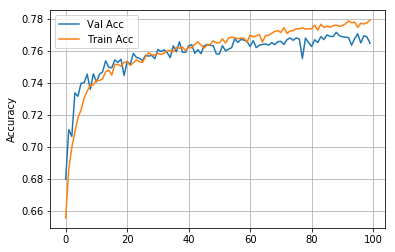

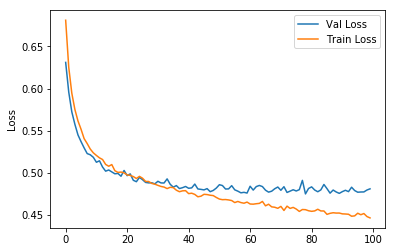

In [133]:
print(H.history.keys())

val_acc=H.history['val_acc']
acc = H.history['acc']

val_loss=H.history['val_loss']
loss = H.history['loss']


#fig= plt.figure(figsize=(15,10))
plt.plot(val_acc,label='Val Acc')
plt.plot(acc,label='Train Acc')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


#fig= plt.figure(figsize=(15,10))
plt.plot(val_loss,label='Val Loss')
plt.plot(loss,label='Train Loss')

plt.ylabel('Loss')
plt.legend()
plt.show()

In [135]:
y_pred = np.argmax(model.predict(X_test), axis=1)

y_true = Y_test
print(confusion_matrix(y_true, y_pred))
print(accuracy_score(y_true, y_pred))

[[3928 1864]
 [ 840 4861]]
0.7647263551727138
